# Représentation graphique en hémicycle de la théorie d'Abric sur les cartes cognitives

On utilise deux dimensions pour classer les mots énoncés dans les cartes cognitive, que l'on utilise dans _un système de coordonnées polaires_ :

- la **fréquence**, qui s'appuie sur le _nombre d'occurrences_, c'est-à-dire le nombre de cartes qui contiennent le mot, ou dit autrement le nombre de répondants qui ont employé ce mot. La fréquence sera représentée par le **rayon** dans le système polaire.
- l'**importance**, qui s'appuie sur la _position médiane des occurrences_ dans les cartes. Chaque position est ramenée à un pourcentage (première position 100%, dernière position = 100/(longueur de la carte)). L'importante sera représentée par **l'angle** dans le système polaire.

On reprend les calculs faits [la première partie de l'analyse](https://nbviewer.org/github/romulusFR/cnrt_cartes_cog/blob/main/cogmaps_v3/analyse_chapitre_these.ipynb). On supprime une bonne fois pour toute les mots qui n'ont pas été cité **au moins 3 fois**.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# import altair as alt
import seaborn as sns
import numpy as np

# sns.set_theme()


LABEL_NB_OCC = "Nb. occ."
LABEL_POS_MED = "Pos. médiane"
LABEL_POS_MOY = "Pos. moyenne"
OUTPUT_FOLDER = Path("../output_v3")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)
MIN_OCC_THRESHOLD = 3

SRC_MINE_TOUS = Path(OUTPUT_FOLDER / "frequence-importance-la mine et le nickel (tous)-2023-08-23.xlsx")
df_complete = pd.read_excel(SRC_MINE_TOUS, index_col=0)
df_mine_tous = df_complete[df_complete[LABEL_NB_OCC] >= MIN_OCC_THRESHOLD].copy()


df_mine_tous


,Nb. occ.,Pos. médiane,Pos. moyenne
nickel,189,87.50,78.22
pollution,182,57.14,58.47
économie,116,65.15,64.05
camion,104,69.05,67.04
environnement,100,62.50,59.14
...,...,...,...
lieu,3,53.33,53.33
ftn,3,33.33,44.01
développement durable,3,28.57,33.41
construction,3,40.00,48.89


On affiche l'histogramme des occurrences sur un échelle linéaire et une échelle logarithmique qu'on utilisera par la suite.

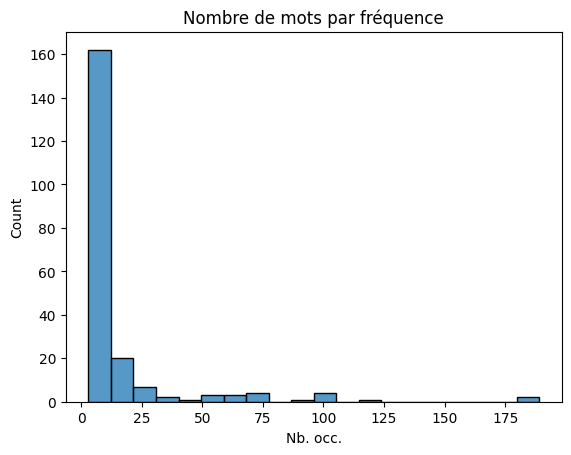

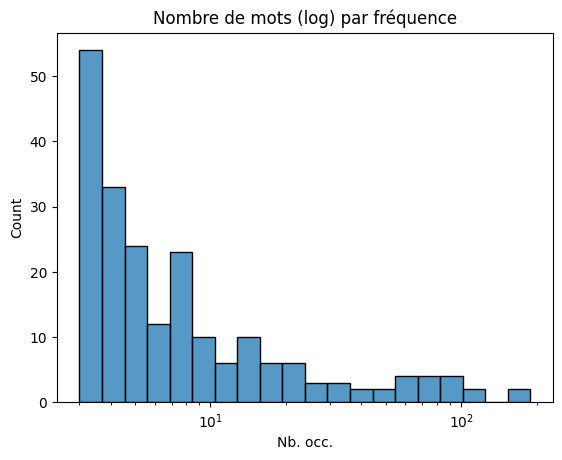

In [2]:
sns.histplot(df_mine_tous, x = LABEL_NB_OCC, bins=20, multiple="dodge", log_scale=False).set(title="Nombre de mots par fréquence")
plt.show()
sns.histplot(df_mine_tous, x = LABEL_NB_OCC, bins=20, multiple="dodge", log_scale=True).set(title="Nombre de mots (log) par fréquence")
plt.show()

On avait utilisé deux indicateurs différent pour la positions : la moyenne et la médiane.
Ici on les trace ensemble pour illustrer que les deux sont au final assez semblables.
On utilisera **la médiane** dans la suite.

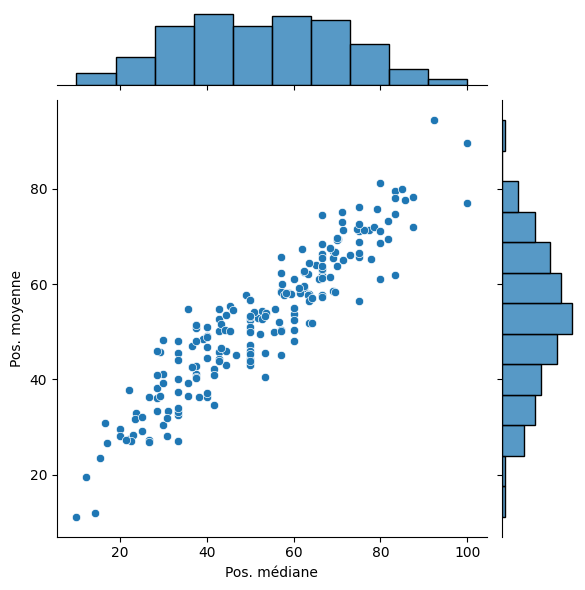

In [3]:
sns.jointplot(data=df_mine_tous, x=LABEL_POS_MED, y=LABEL_POS_MOY)
plt.show()


On va maintenant diviser les mots énoncés en quatre catégories que sont les cases du schéma d'Abric :

- seuil fréquent/non fréquent : si le mot est souvent cité,
- seuil important/non important : si le mot est cité dans les premiers.

Pour le seuil de fréquence, on calcule le nombre d'occurrences qui représentera un certain pourcentage des énonciations, 67% dans l'exemple.
Autrement dit, les mots fréquents sont les plus cités tels que si on les considère tous, ils représentent ensemble 67% des mots énoncés. Pour cela, il fois que le mot soit cité **au moins 7 fois** sur le jeu complet de cartes cognitives ou **au moins 18 fois** si on supprime les mots cités seulement 1 ou 2 fois.

Pour le seuil d'importance, on fixe arbitrairement à 67% ou 50%.

Le choix de ces seuils modifie le nombre de mots énoncés que l'on va retrouver dans chacun des quatre cadrans d'Abric.

In [4]:
nb_occ_threshold = 2/3
pos_threshold = 200/3 # NB : c'est déjà un %
filter_occ = df_mine_tous[LABEL_NB_OCC].cumsum() <= (nb_occ_threshold * df_mine_tous[LABEL_NB_OCC].sum())
filter_pos = df_mine_tous[LABEL_POS_MED] >= pos_threshold
min_occ_frequent = df_mine_tous[filter_occ].min()[LABEL_NB_OCC]

print(f"Limite de fréquence à {min_occ_frequent} occurences pour {nb_occ_threshold:.0%}")

map_occ_pos = {
    (True, True): "Fréquent/Important",
    (True, False): "Fréquent/Non-important",
    (False, True): "Non-fréquent/Important",
    (False, False): "Non-fréquent/Non-important",
}

LABEL_CAT = "Catégorie"

df_mine_tous[LABEL_CAT] = [map_occ_pos[(o, p)] for o, p in zip(filter_occ, filter_pos)]
df_mine_tous


Limite de fréquence à 18.0 occurences pour 67%


,Nb. occ.,Pos. médiane,Pos. moyenne,Catégorie
nickel,189,87.50,78.22,Fréquent/Important
pollution,182,57.14,58.47,Fréquent/Non-important
économie,116,65.15,64.05,Fréquent/Non-important
camion,104,69.05,67.04,Fréquent/Important
environnement,100,62.50,59.14,Fréquent/Non-important
...,...,...,...,...
lieu,3,53.33,53.33,Non-fréquent/Non-important
ftn,3,33.33,44.01,Non-fréquent/Non-important
développement durable,3,28.57,33.41,Non-fréquent/Non-important
construction,3,40.00,48.89,Non-fréquent/Non-important


On va lister les mots appartenant à chacune des quatre catégories.

In [5]:
for cat in map_occ_pos.values():
    idx = df_mine_tous[df_mine_tous[LABEL_CAT] == cat].index.to_list()
    print(f"Catégorie {cat} : {len(idx)} mots énoncés")
    print(idx)

Catégorie Fréquent/Important : 16 mots énoncés
['nickel', 'camion', 'emploi', 'argent', 'richesse', 'terre', 'exploitation', 'minerai', 'ressource', 'caillou', 'terre rouge', 'nature', 'engin', 'industrie', 'goro', 'machine']
Catégorie Fréquent/Non-important : 18 mots énoncés
['pollution', 'économie', 'environnement', 'travail', 'usine', 'montagne', 'destruction', 'sln', 'conflit', 'déforestation', 'exportation', 'développement', 'métal', 'extraction', 'fer', 'cailloux', 'érosion', 'impact']
Catégorie Non-fréquent/Important : 43 mots énoncés
['mine', 'revenu', 'roche', 'or', 'camions', 'pierre', 'sale', 'la terre', 'doniambo', 'garniérite', 'matière première', 'creuser', 'pioche', 'vert', 'écologie', 'carrière', 'changement', 'latérite', 'ressource naturelle', 'rocher', 'maquis minier', 'usine du sud', 'boue', 'smsp', 'nord', 'usines', 'outil', 'prospection', 'vkp', 'marché (économique)', 'profit', 'chargement', 'granite', 'diamant', 'productivité', 'crayon', 'territoire', 'serpentine'

On a maintenant une première visualisation des quatre catégories comme suit, où on voit les effets des deux seuils.

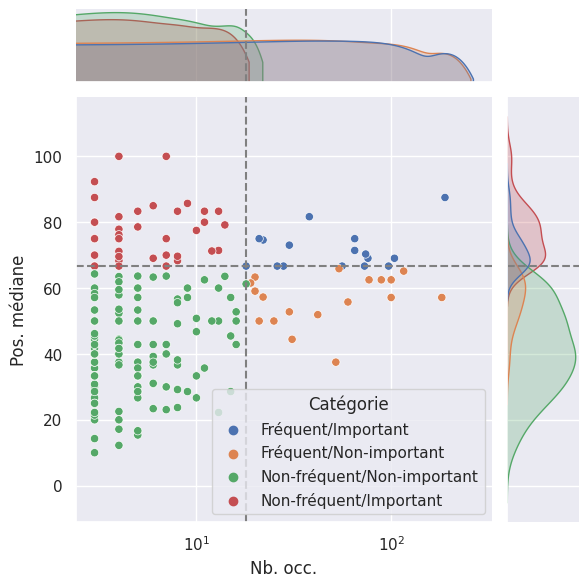

In [25]:
# <https://stackoverflow.com/questions/45439833/how-to-log-scale-in-seaborn>
ax = sns.jointplot(data=df_mine_tous, x=LABEL_NB_OCC, y=LABEL_POS_MED, kind="scatter", hue=LABEL_CAT)
# display(ax)
ax.ax_marg_x.set(xscale='log', yscale='log')
ax.refline(x=min_occ_frequent, y=pos_threshold)
plt.show()


On lance in clustering pour décomposer en 4 parties.

In [37]:
from sklearn.cluster import KMeans
NB_CLUSTERS = 4
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, n_init="auto").fit(df_mine_tous[[LABEL_POS_MED, LABEL_NB_OCC]])
LABEL_CLUSTER = "Cluster"
df_mine_tous[LABEL_CLUSTER] = kmeans.labels_
kmeans.cluster_centers_

array([[51.16028571,  9.34285714],
       [66.52588235, 92.76470588],
       [74.12344828,  8.51724138],
       [30.23723077,  5.26153846]])

Maintenant, on va représenter un _scatter plot_ dans un système de coordonnées polaires.

In [7]:
LABEL_NB_OCC_SCALED = f"{LABEL_NB_OCC} (scaled)"
LABEL_POS_MED_SCALED = f"{LABEL_POS_MED} (scaled rad.)"
x = df_complete[LABEL_POS_MED]
df_mine_tous[LABEL_POS_MED_SCALED] = np.pi * (1 - (x - x.min()) / (x.max() - x.min()))
theta = df_mine_tous[LABEL_POS_MED_SCALED]

y = np.log(df_complete[LABEL_NB_OCC])
df_mine_tous[LABEL_NB_OCC_SCALED] = 1 - (y - y.min()) / (y.max() - y.min())
r = df_mine_tous[LABEL_NB_OCC_SCALED]
# display(df_mine_tous)


**NOTE** quand on utilise les coordonnées polaires dans plt:

- `x = theta` : l'angle, la position des occurrences
- `y = r` : le rayon, le nombre d'occurrences


Dans le graphique, on va voir apparaître les deux seuils dans l'hémicycle :

- pour la fréquence, c'est la distance par rapport au centre : le premier rang (interne) est composé des mots bleus et orange : les fréquents
- pour l'importance, on voit un angle à 60 degré si on prend une limite à 67% (90 degré à 50%) : comme sur une représentation de l'hémicycle : à droite les importants (bleu et rouge) et à gauche les non importants (verts et orange)

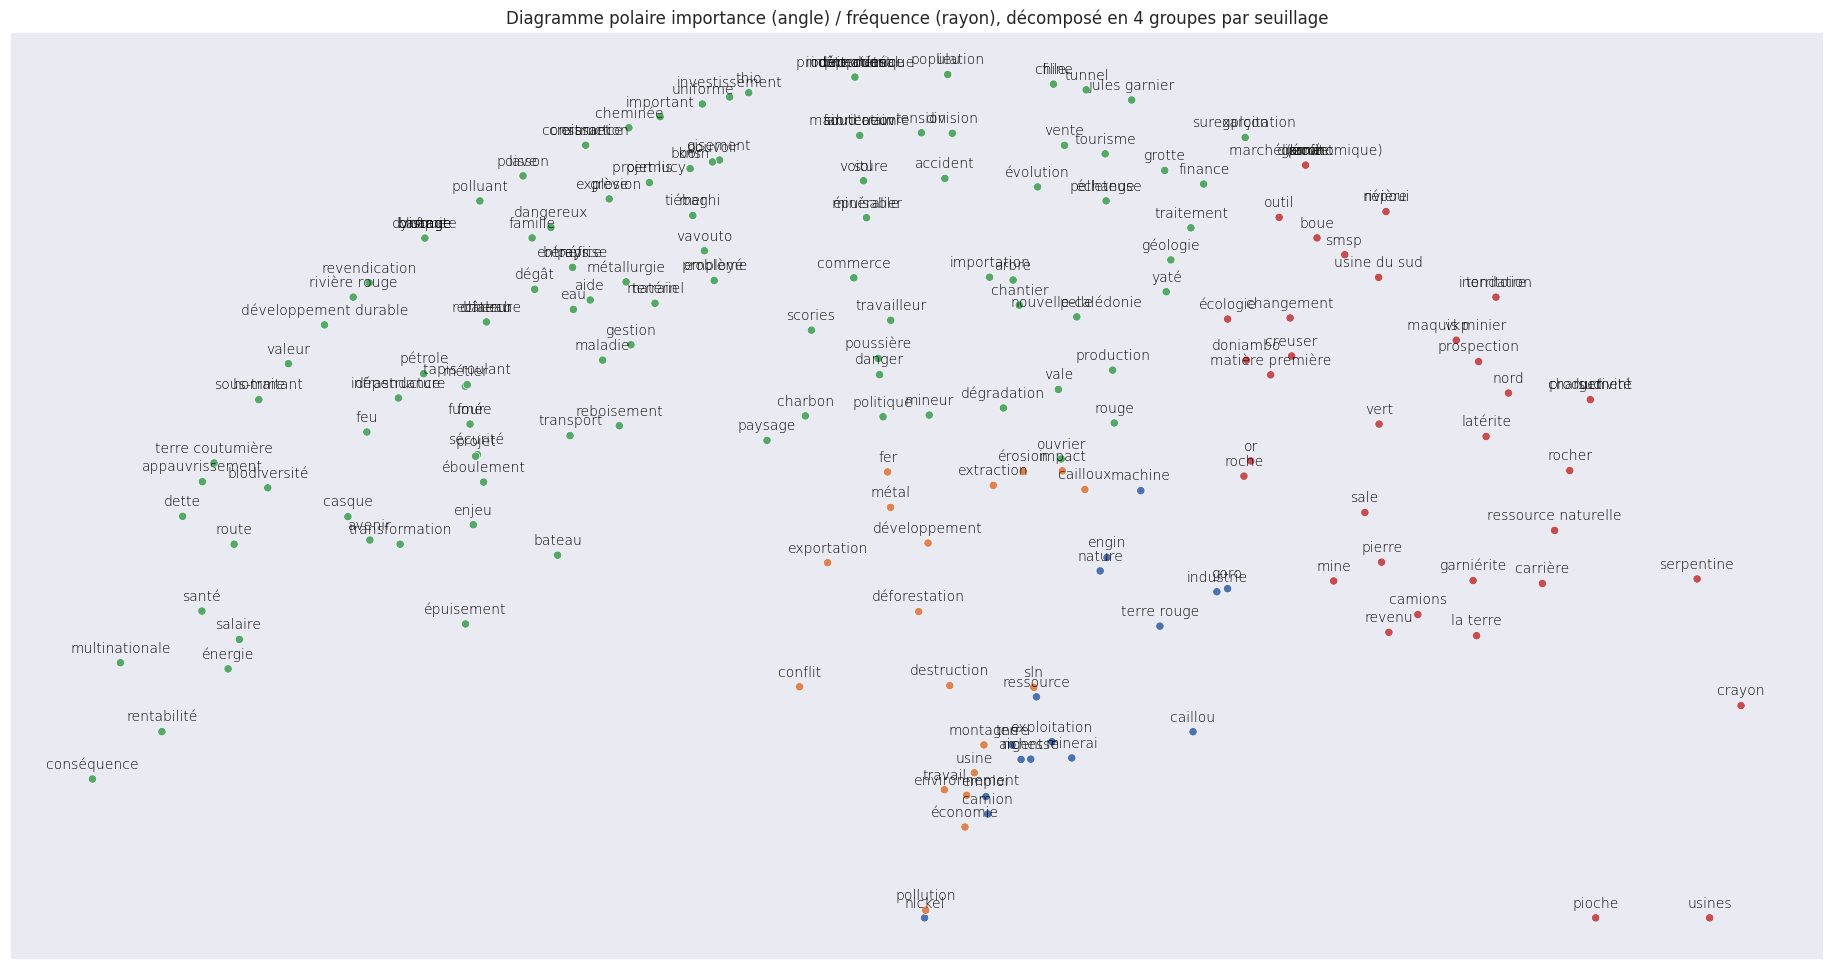

In [32]:
sns.set(rc={"figure.figsize": (11.7*2, 8.27*2)})
df_mine_tous["x"] = df_mine_tous[LABEL_NB_OCC_SCALED] * np.cos(df_mine_tous[LABEL_POS_MED_SCALED])
df_mine_tous["y"] = df_mine_tous[LABEL_NB_OCC_SCALED] * np.sin(df_mine_tous[LABEL_POS_MED_SCALED])
ax = sns.scatterplot(data=df_mine_tous, x="x", y="y", hue=LABEL_CAT)
ax.set_aspect("equal")
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set(yticklabels=[])
ax.set(ylabel=None)
ax.grid(False)
# sns.despine(ax=ax)
plt.legend([], [], frameon=False)

# Loop through the data points
for row in df_mine_tous.itertuples():
    plt.text(row.x, row.y + 0.01, row.Index, horizontalalignment="center", size="small", color="black", weight="light")

plt.title("Diagramme polaire importance (angle) / fréquence (rayon), décomposé en 4 groupes par seuillage")
plt.show()


Le même que précédent, mais avec des points dont la taille est fonction de la fréquence et un dégradé sur la partie radiale. 

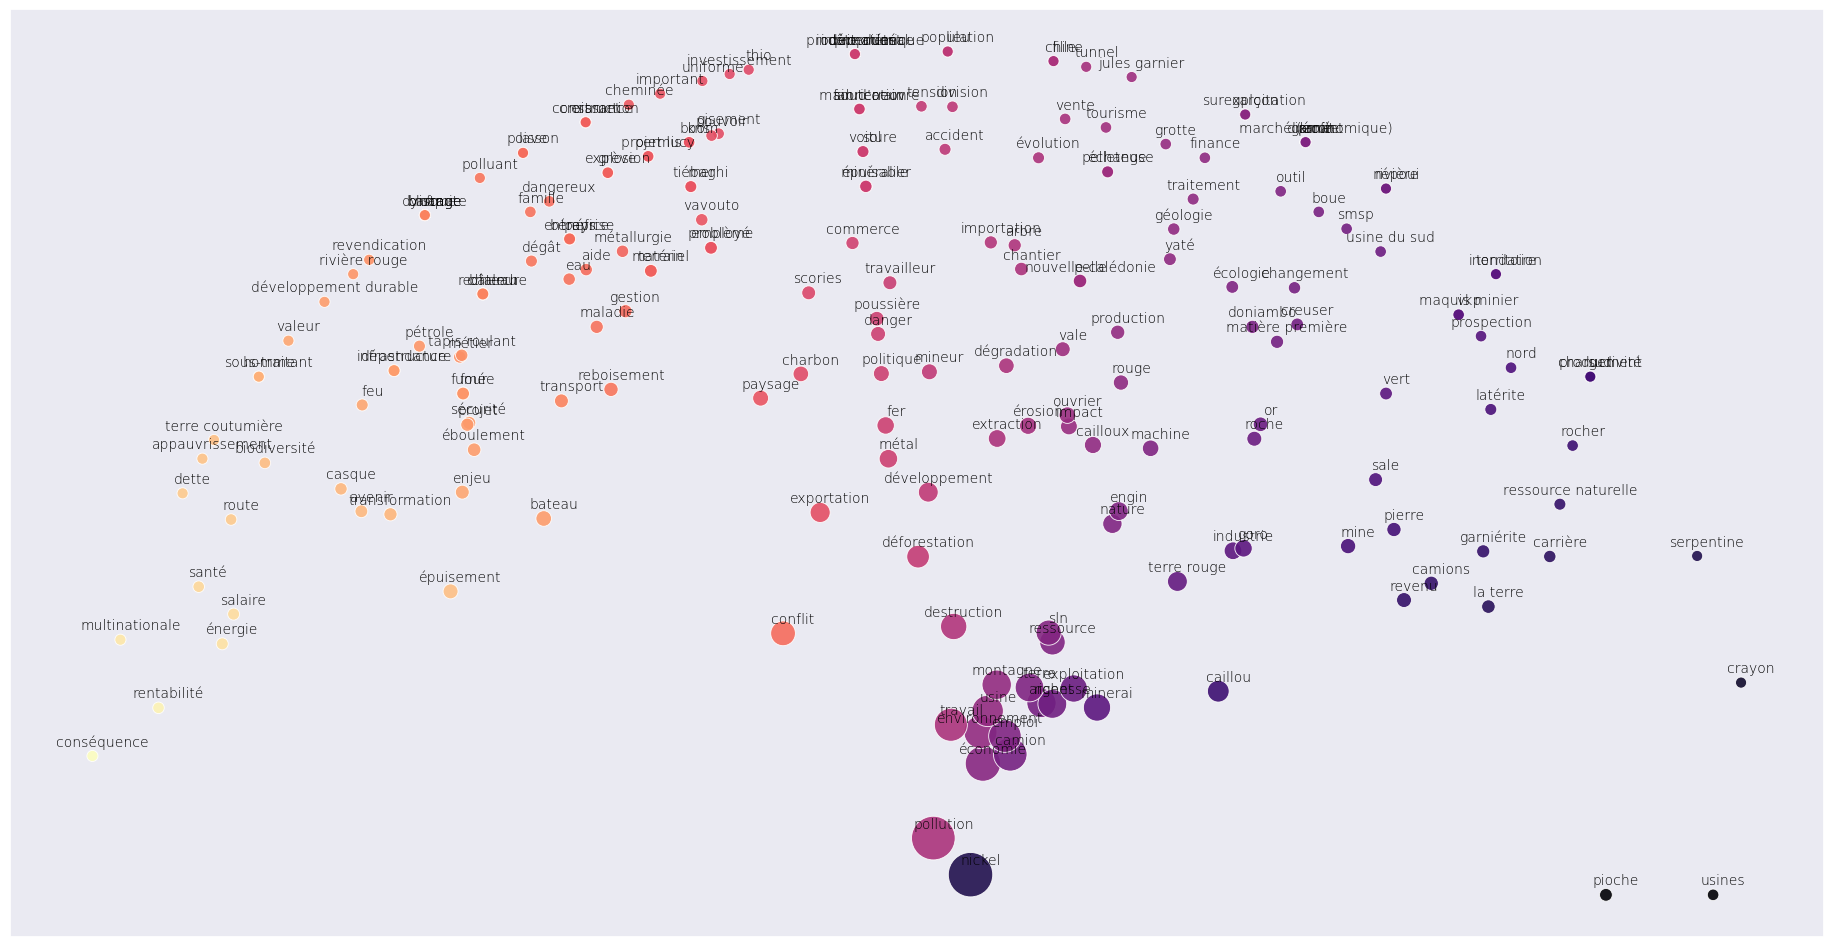

In [28]:
sns.set(rc={"figure.figsize": (11.7 * 2, 8.27 * 2)})
r_offset = 0.05
df_mine_tous["x"] = (r_offset + df_mine_tous[LABEL_NB_OCC_SCALED]) * np.cos(df_mine_tous[LABEL_POS_MED_SCALED])
df_mine_tous["y"] = (r_offset + df_mine_tous[LABEL_NB_OCC_SCALED]) * np.sin(df_mine_tous[LABEL_POS_MED_SCALED])
ax = sns.scatterplot(
    data=df_mine_tous,
    x="x",
    y="y",
    hue=LABEL_POS_MED_SCALED,
    palette="magma",
    size=LABEL_NB_OCC,
    sizes=(64, 1024),
    alpha=0.9,
)
ax.set_aspect("equal")
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set(yticklabels=[])
ax.set(ylabel=None)
ax.grid(False)
# sns.despine(ax=ax)
plt.legend([], [], frameon=False)

# Loop through the data points
for row in df_mine_tous.itertuples():
    plt.text(
        row.x + 0.01, row.y + 0.01, row.Index, horizontalalignment="center", size="small", color="black", weight="light"
    )

plt.title("Diagramme polaire importance (angle) / fréquence (rayon), couleur fonction de la position")
plt.show()

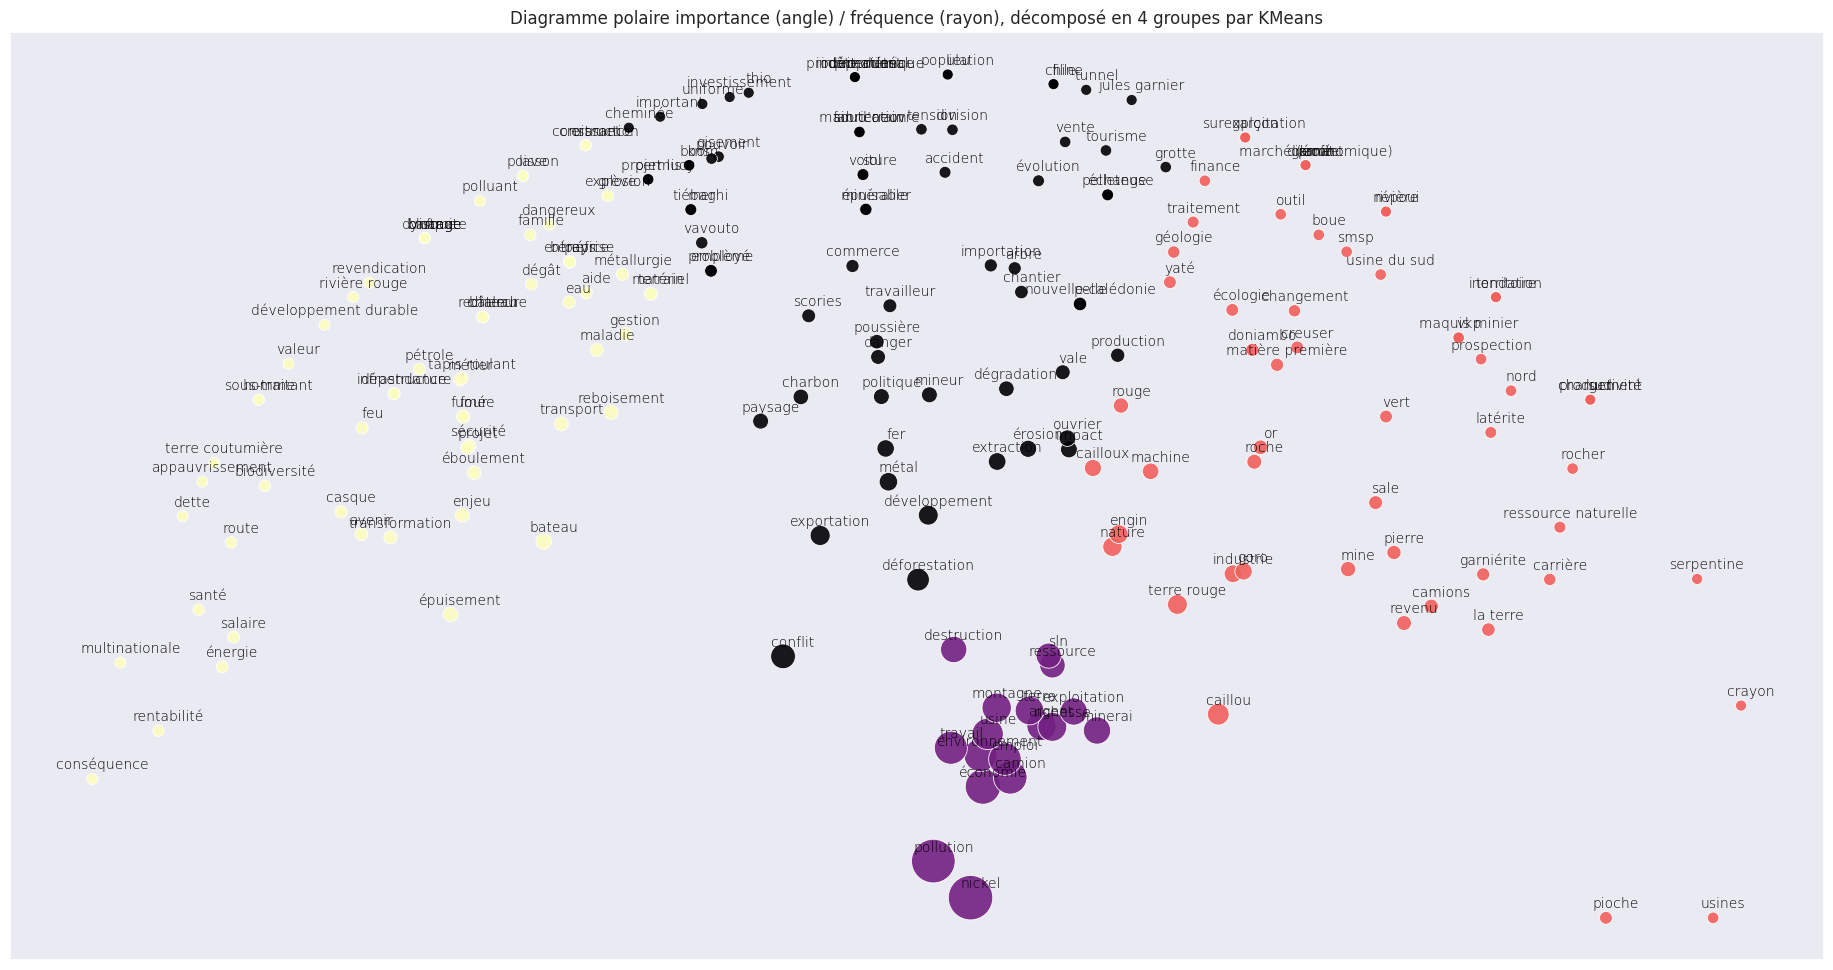

In [38]:
sns.set(rc={"figure.figsize": (11.7 * 2, 8.27 * 2)})
r_offset = 0.05
df_mine_tous["x"] = (r_offset + df_mine_tous[LABEL_NB_OCC_SCALED]) * np.cos(df_mine_tous[LABEL_POS_MED_SCALED])
df_mine_tous["y"] = (r_offset + df_mine_tous[LABEL_NB_OCC_SCALED]) * np.sin(df_mine_tous[LABEL_POS_MED_SCALED])
ax = sns.scatterplot(
    data=df_mine_tous,
    x="x",
    y="y",
    hue=LABEL_CLUSTER, #LABEL_POS_MED_SCALED,
    palette="magma",
    size=LABEL_NB_OCC,
    sizes=(64, 1024),
    alpha=0.9,
)
ax.set_aspect("equal")
ax.set(xticklabels=[])
ax.set(xlabel=None)
ax.set(yticklabels=[])
ax.set(ylabel=None)
ax.grid(False)
# sns.despine(ax=ax)
plt.legend([], [], frameon=False)

# Loop through the data points
for row in df_mine_tous.itertuples():
    plt.text(
        row.x + 0.01, row.y + 0.01, row.Index, horizontalalignment="center", size="small", color="black", weight="light"
    )
plt.title(f"Diagramme polaire importance (angle) / fréquence (rayon), décomposé en {NB_CLUSTERS} groupes par KMeans")
plt.show()


In [10]:
df_mine_tous.sort_values(LABEL_POS_MED, ascending=False)

,Nb. occ.,Pos. médiane,Pos. moyenne,Catégorie,Pos. médiane (scaled rad.),Nb. occ. (scaled),x,y
usines,4,100.00,89.58,Non-fréquent/Important,0.000000,0.735528,0.785528,0.000000
pioche,7,100.00,76.93,Non-fréquent/Important,0.000000,0.628767,0.678767,0.000000
crayon,3,92.31,94.41,Non-fréquent/Important,0.254304,0.790411,0.813382,0.211423
nickel,189,87.50,78.22,Fréquent/Important,0.413367,0.000000,0.045789,0.020085
serpentine,3,87.50,72.06,Non-fréquent/Important,0.413367,0.790411,0.769626,0.337589
...,...,...,...,...,...,...,...,...
salaire,5,16.67,30.91,Non-fréquent/Non-important,2.755673,0.692958,-0.688315,0.279658
énergie,5,15.38,23.43,Non-fréquent/Non-important,2.798332,0.692958,-0.699615,0.250049
multinationale,3,14.29,11.90,Non-fréquent/Non-important,2.834378,0.790411,-0.801063,0.254144
rentabilité,4,12.24,19.45,Non-fréquent/Non-important,2.902170,0.735528,-0.763121,0.186281
